<span style='background-color: #fff5b1'># 오늘의 한 걸음  🚶🏽‍♂️: 뉴스기사 요약하기</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리   
        -1. 결측치, 중복치 제거
        -2. 정규화( do not = don't 처럼 같은 의미의 말 통일화) / 불용어 제거
        -3. 길이 통일화
        -4. 데이터 토큰화
        -5. train test split
        -6. 단어 사전 vocabulary 생성
        -7. padding 값 생성
        
    2-3. 모델 학습 / 추상요약 Abstract Summarize
        -1. seq2seq 모델 생성
        -2. Attention machanism 추가
        -3. 완성 모델로 학습
        
    2-4. 데이터 평가 
    2-5. 번외 / 추출요약 Extract Summarize

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


주어진 신문 기사 내용을 훌륭하게 요약해보는 프로그램을 만든다!

[데이터 출처 : 깃허브 suunyshy](https://github.com/sunnysai12345/News_Summary)

Exploration 과정에서 

1. 스스로 데이터 전처리 하기
2. seq2seq 모델 사용하기
3. Attention machanism 사용하기

를 중점적으로 다룬다


- 오늘의 rubric

|평가문항|상세기준|
|---|---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

## 1-2. 사용하는 라이브러리

In [2]:
import numpy as np
import pandas as pd  # 데이터 배열 처리 라이브러리

import requests
import urllib.request #웹사이트 데이터 로드 라이브러리

import os # 데이터 경로 설정 라이브러리

import re # 데이터 전처리 시 사용할 정규표현식 라이브러리
from bs4 import BeautifulSoup #데이터 전처리 시 활용 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리


from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
#NLP 프로세싱 라이브러리

from tensorflow.keras.layers import AdditiveAttention # 어텐션 매커니즘 라이브러리

from summa.summarizer import summarize #추출 요약 시 사용하는 라이브러리


import warnings #오류 패싱 라이브러리


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 2. GAME
## 2-1. 데이터 읽어오기

우리의 데이터는 깃허브의 sunnyshy 라는 분이 모은 기사 자료이다.  

- 자료 설명 :  
2017년 2월부터 8월 까지의 힌두, 인디언 타임즈, 가디언 뉴스 기사 스크랩


- 자료 요약 :  
행 : 98400 개  
열 : headline, text

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

#

data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.tail()

,headlines,text
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


In [5]:
len(data)

98401

## 2-2.데이터 전처리

### 2-2-1. 중복값, 결측값 제거

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


- 총 데이터가 98401 행 인데 두 자료 모두 더 적은 데이터를 가지고 있다.  
헤드라인은 같을 수도 있지만, 기사 내용이 완벽히 똑같을 순 없으므로 text의 중복값만 제거해준다.

In [7]:
data.drop_duplicates(subset = ['text'], inplace=True) # Text 칼럼이 같은 거 삭제
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 결측값은 없다.

### 2-2-2. 정규화 / 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

최종결과에 있어 요약 데이터는 불용어(my, during 등) 은 있는 것이 효과적이라고 생각했다.  
때문에 전처리 시도 시 headlines 데이터에는 불용어 제거를 하지 않도록 한다.

In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

하나의 기사를 뽑아 번역해 보면 다음과 같다.

**라즈쿠마르 히라니 소남 카푸어는 성추행 혐의에 대해 알려진 수년간의 미투 운동이 탈선했다며 여성 사건에는 예비 판단이 필요하다고 믿는다고 말했다.**

깔끔하게 전처리 되었음을 확인 가능하다.

In [13]:
clean_headlines = []
# 전체 Text 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_headlines[:5])

Text 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


하나의 기사를 뽑아 번역해 보면 다음과 같다.

**유명하기로 알려진 히라니 '만약 지금까지의 미투 운동이 진정한 미투 운동이 아니라면?'**

깔끔하게 전처리 되었다.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [15]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


전처리에서 필요없는 특수문자와 불용어 를 제거하는 과정 동안,  
`''` 밖에 남지 않은 데이터가 있을 수 있다. 때문에 그 값을 Null 로 바꿔 없애도록 한다.

In [17]:
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

없어진 값은 없는 것으로 보인다.

### 2-2-3. 기사 길이 통일화
너무 긴 문장은 모델 학습에 악영향을 미친다.  
모델 학습 시에는 모든 문장의 길이를 일치시켜야 하는데,  
다른 문장들에 과도한 padiing 값이 설정되기 때문이다.

때문에 모든 기사의 길이 분포를 확인하고 적정선에서 데이터를 제거해준다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


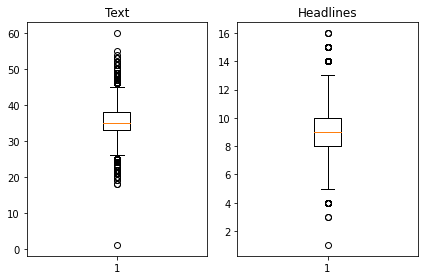

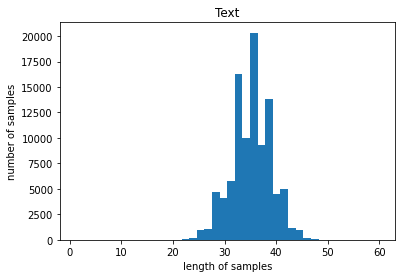

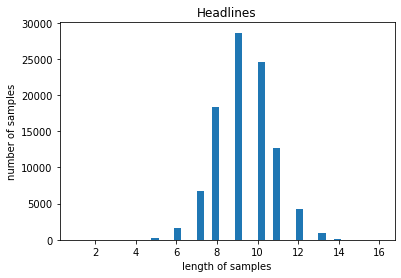

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
head_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(head_len)))
print('요약의 최대 길이 : {}'.format(np.max(head_len)))
print('요약의 평균 길이 : {}'.format(np.mean(head_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

한 단어의 짧은 기사부터 (대체 무슨 문장일까? ) 60단어의 긴 문장까지 있다.    

하나의 단어만 있는게 뭔가 쓸데 없는 느낌이 들어 확인해보았다.

In [19]:
a = data['text']

b = list(map(lambda x : len(x.split()), a ))
c = {leng:index for index, leng in enumerate(b)}

c[1]

52

In [20]:
data.loc[52]

headlines    headlines
text              text
Name: 52, dtype: object

headlines 에 headlines, text에 text 가 들어있는 것으로 보아  
제거해주는 것이 좋겠다.



In [21]:
data = data.drop(52, axis=0)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98359


평균은 35단어로 그래프를 통해 보면 20~45단어 사이에 가장 많은 기사가 있는 것을 확인할 수 있다.

헤드라인은 1단어부터 16단어까지 있으며, 6~12단어 사이에 가장 많은 헤드라인이 있다.

우리는 기사는 38단어, 헤드라인은 11단어에서 끊어주도록 하겠다.

In [24]:
text_max_len = 38
headlines_max_len = 10

이 단어 길이로 끊었을 때, 유지되는 기사의 비율은 어느정도일까?


In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163360749905957
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162954076393619


20%는 버려주자

In [26]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65294


### 2-2-4. 데이터 토큰화

데이터로 학습을 시켜주기 위해선 이미 요약된 문장에 start 싸인과 end 싸인을  
줄 필요가 있다.

start는 인풋, end 는 라벨링이라 생각하면 이해가 편하다

start 에 나오는 문장에 대한 결과가 end 문장이 나와야 하는 것이다.



In [27]:
data['decoder_input'] =data['headlines'].apply(lambda x : 'sostoken ' + x)

data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


최종적으로 데이터 형태를 Data Frame 에서 Numpy 배열 형태로 바꾼다.

In [28]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 2-2-5. Train Test Split

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[30102 27448  4800 ... 15514 13073  7717]


In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices] #배열과 숫자배열끼리 곱하면 숫자배열대로 배열의 순서가 바뀐다.

충분히 섞인 자료들을 8대 2의 비율로 나누도록 하겠다.

In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13058


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13058
테스트 레이블의 개수 : 13058


### 2-2-6. 단어사전 Vocabulary 생성

우리가 가지고 있는 단어들을 바탕으로 단어사전을 만들어야 한다.
이를 위해 Keras 의 `tokenizer` 클래스로 이미 정의된 단어들 중 우리가 가진 단어들만  
`fit` 메서드를 통해 가지고 오겠다.

In [33]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

`fit` 메서드를 통해 우리 데이터 내부 모든 단어를 가져왔다,  
하지만 우리가 지닌 모든 단어를 이용할 필요는 없다  
68000번 중 1~2번밖에 나오지 않는 단어는 오히려 학습에 방해가 된다.  

그러므로 빈도수가 낮은 단어의 비율을 확인 후 적절히 제거하도록 한다.

In [34]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57331
등장 빈도가 8번 이하인 희귀 단어의 수: 41717
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15614
단어 집합에서 희귀 단어의 비율: 72.76517067555075
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.5037462949041815


8번 이하 나오는 단어가 전체 단어의 80%나 차지하지만,  
실상 반복되는 비율은 고작 5%이다. 때문에 8번 이하로 나오는 단어들은  
제거하도록 한다.

In [35]:
src_vocab = 16000 #빈도가 높은 상위 16000개의 단어를 남긴다
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


`text_to_sequence()` 메서드를 사용해 정제한 단어사전의 단어들을 정수화시킨다.  
현재 16000개의 단어가 있으므로 16000까지의 정수가 생성될 것이다.

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:1])

[[47, 643, 8421, 12625, 53, 1, 983, 1071, 4, 1696, 325, 765, 52, 12625, 1, 719, 6098, 59, 5717, 4474, 1089, 8, 619, 13, 581, 476, 5631, 5, 218, 1333, 7509, 12625, 3]]


위와 같이 decoder 데이터 (sos + 기사) 도 함께 tokenizer 처리를 해준다.

In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이것을 두번 해주는 이유는 우리가 seq2seq 모델을 쓰기 때문이다.

우리는 LSTM 이 두번 반복되는 모델을 사용하기에 각 모델에 들어가는 input,  
즉, 기사 단어사전 과 headline 단어사전 을 다르게 형성해야 한다.



In [39]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25912
등장 빈도가 4번 이하인 희귀 단어의 수: 16520
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9392
단어 집합에서 희귀 단어의 비율: 63.75424513738809
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.533552176581175


In [40]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 711, 476, 486, 10, 1996, 4, 69, 805, 37, 125], [1, 1207, 1208, 748, 6, 239, 4695, 15, 8385, 37], [1, 1641, 3, 6940, 2921, 9394, 424, 409, 8386, 38, 159], [1, 66, 2592, 91, 661, 3, 1997, 30, 11, 241, 4465], [1, 8387, 103, 3908, 233, 727, 310, 103, 305]]
target
decoder  [[711, 476, 486, 10, 1996, 4, 69, 805, 37, 125, 2], [1207, 1208, 748, 6, 239, 4695, 15, 8385, 37, 2], [1641, 3, 6940, 2921, 9394, 424, 409, 8386, 38, 159, 2], [66, 2592, 91, 661, 3, 1997, 30, 11, 241, 4465, 2], [8387, 103, 3908, 233, 727, 310, 103, 305, 2]]


보면 sostoken 은 1로, eostoken 은 2 로 표시되고 있다.

#### 여기서 잠깐 ! 🖐

빈도가 적은 단어를 삭제했기 때문에 다시 결측치가 생겼을 수도 있다.  
한번 더 확인해보자.

In [41]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))


삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


다행히 삭제할 데이터는 존재하지 않는다.

### 2-2-7. padding 처리

In [42]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2-3.모델 학습

### 2-3-1. seq2seq 모델 생성
seq2seq 란 두 개의 RNN 모델을 이어 붙여 사용하는 모델로써,  
앞의 모델을 `encoder` , 뒤의 모델을 `decoder` 라고 한다.

인코더에서는 원본 데이터를 학습시켜 벡터 정보를 불러온다.
디코더에서는 그 문맥 정보를 가지고 있는 벡터 정보르 전달받아 결과물을 내놓는다.

seq2seq 모델 방식으로 RNN 대신 LSTM을 통해 학습을 시켜보겠다.

In [43]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 #hidden state

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 차원은 128,  
히든 사이즈 256 으로 하고

세 개의 LSTM 레이어를 씌웠다.
LSTM 레이어에서는 `Dropout` 과 `Recurrent Dropout` 을 동시에 사용한다.
이처럼 두 가지 Dropout 정규화를 사용하는 기법을 Variational Dropout 이라 한다.

In [44]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

두번째 sequence 인 디코더 모델도 기본적인 LSTM 틀은 같다. 하지만  
`initial_state=[state_h, state_c]` 을 통해서 첫 sequence의 히든값과 cell(메모) 값을  
가져와야 한다.

In [45]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**여기까지가 기본적인 seq2seq  모델 과정이다.**

하지만 LSTM 을 포함한 RNN 계열의 인공신경망은, 아무리 cell gate (메모 기능)  
을 이용하더라도 문맥 정보의 손실이 생길 수 밖에 없다.

우리는 정보의 손실을 최대한 막기 위해 `Attention Mechanism` 을 사용할 수 있다.

### 2-3-2. Attention Mechanism 추가

이는 기존의 seq2seq 에서 맨 마지막 hidden 값, cell 값 만 가져 오는 기능과 달리,

인코더에서 생성되었던 모든 hidden 과 cell 값을 
모델 생성에 영향을 미친 가중치 만큼을 곱해 가져온다.

In [46]:
# from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 2-3-3. 모델 학습

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
205/205 [==============================] - 127s 539ms/step - loss: 6.4394 - val_loss: 6.0177
Epoch 2/50
205/205 [==============================] - 108s 527ms/step - loss: 5.9092 - val_loss: 5.7130
Epoch 3/50
205/205 [==============================] - 106s 518ms/step - loss: 5.5919 - val_loss: 5.4856
Epoch 4/50
205/205 [==============================] - 106s 517ms/step - loss: 5.3480 - val_loss: 5.3363
Epoch 5/50
205/205 [==============================] - 105s 514ms/step - loss: 5.1283 - val_loss: 5.1619
Epoch 6/50
205/205 [==============================] - 105s 513ms/step - loss: 4.9323 - val_loss: 4.9974
Epoch 7/50
205/205 [==============================] - 106s 516ms/step - loss: 4.7522 - val_loss: 4.9039
Epoch 8/50
205/205 [==============================] - 105s 513ms/step - loss: 4.5953 - val_loss: 4.8213
Epoch 9/50
205/205 [==============================] - 105s 511ms/step - loss: 4.4517 - val_loss: 4.7645
Epoch 10/50
205/205 [==============================] - 105s 515m

In [87]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 165s 581ms/step - loss: 6.0458 - val_loss: 5.6339
Epoch 2/50
269/269 [==============================] - 156s 579ms/step - loss: 5.4679 - val_loss: 5.2470
Epoch 3/50
269/269 [==============================] - 152s 563ms/step - loss: 5.1238 - val_loss: 5.0133
Epoch 4/50
269/269 [==============================] - 149s 553ms/step - loss: 4.8506 - val_loss: 4.7871
Epoch 5/50
269/269 [==============================] - 151s 561ms/step - loss: 4.6278 - val_loss: 4.6418
Epoch 6/50
269/269 [==============================] - 153s 570ms/step - loss: 4.4463 - val_loss: 4.5135
Epoch 7/50
269/269 [==============================] - 151s 562ms/step - loss: 4.2904 - val_loss: 4.4163
Epoch 8/50
269/269 [==============================] - 150s 559ms/step - loss: 4.1543 - val_loss: 4.3388
Epoch 9/50
269/269 [==============================] - 149s 553ms/step - loss: 4.0311 - val_loss: 4.2811
Epoch 10/50
269/269 [==============================] - 151s 561m

## 2-4.데이터 평가

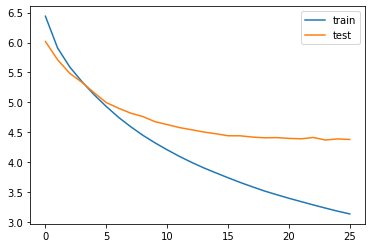

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

학습한 모델을 사용하기 위해서는 숫자로 바꾼 데이터를  
다시 텍스트화 시킬 필요가 있다.

In [49]:
src_index_to_word = src_tokenizer.index_word 
# 원문 단어 집합에서 정수 -> 단어를 얻음

tar_word_to_index = tar_tokenizer.word_index 
# headline 단어 집합에서 단어 -> 정수를 얻음

tar_index_to_word = tar_tokenizer.index_word 
# headline 단어 집합에서 정수 -> 단어를 얻음

#### 여기서 또 잠깐 ! 🖐

seq2seq 모델을 이용했다면, 우리는 주의해야 한다.
무엇을? 바로 결과물을 출력할 때 별도로 모델 설계를 또 해주어야 한다는 것을!

왜냐면 seq2seq 에서는 

디코더 (두번째 seq ) 에 `sos+문장전체` 를 넣고 `문장전체 + eos` 를 결과로 생각해  
학습시켰다.  

그러나 정답 문장이 없는 실제 구동 시에는 문장을 얼마나 길게 할지 정해져 있지 않아서  
그 길이 추론을 위한 모델 설계를 별도로 해주어야 한다.



In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 
#초기 상태(initial_state)를 이전 시점의 상태로 사용. 
#이는 뒤의 함수 decode_sequence()에 구현

# 훈련 과정에서와 달리 
#LSTM의 리턴하는 은닉 상태와 
#셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])


별도 모델 생성에도 `attention machanism` 을 사용한다.

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


**그리고**

이 모델에서 단어 길이를 예측하는 함수를 넣는다.

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

나온 결과물을 정수 시퀀스에서 텍스트 시퀀스로 변환하는 함수도 넣는다.

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [55]:
for i in range(5):
    print("text :", seq2text(encoder_input_test[i]))
    print("실제 headlines :", seq2summary(decoder_input_test[i]))
    print("예측 headlines :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

text : karnataka home minister ramalinga reddy saturday said journalist gauri lankesh would caught weeks stating sit probing murder updated reddy claimed knew committed murder could disclose yet lankesh known stand hindu extremism shot outside bengaluru residence september 
실제 headlines : gauri lankesh will be arrested soon minister 
예측 headlines :  taka cm son lankesh lankesh murder victim son


text : dozen containing one million bees recently reported stolen local park austria police involved residents noticed covers wooden boxes containing removed calculated losses around lakh terms lost honey stolen bees 
실제 headlines : one million bees reported stolen in austrian town 
예측 headlines :  lakh worth crore seized in bengaluru


text : ryanair denmark bound flight forced make emergency landing friday losing one two nose wheels take flight left london airport local time diverted east airport landed several flights delayed ryanair said aircraft landed safely 
실제 headlines : ryanair fligh

간단하게 다섯 개만 번역해 보자.

1. 가우시 란케시 기자는 살인사건의 진상을 알았음에도 밝히지 않아 곧 잡힐 것이다.  


실제 제목: 가우시 란케시 기자, 곧 체포돼  
**예측한 제목** : 란케시, 피해자의 아들? ❌  

2. 오스트리아에서 100만 마리의 벌이 도난되었고, 주민들은 그 나무상자들을 도둑맞았다.  

실제 제목 : 오스트리아 경찰, 100만마리의 벌 도난 사건  
**예측한 제목** : 뱅갈루루에서 압류된 수천만의 크로어 ❌  

3. 덴마크행 비행기가 바퀴를 잃어 문제가 생겼지만 다행히도 안전히 착륙했다.  

실제 제목 : 라이언에어 항공, 비상 착륙 성공.    
**예측한 제목** : 지나가던 새, 비상착륙 후 라이언에어 항공도 비상착륙 발발 🔺  

4. ambani 가 주도한 산업 협정으로 솔루션 제공업체는 무지막지 돈을 벌었다.

실제 제목 : 통신 솔루션 회사를 인수한 ambani  
**예측한 제목** : 합병을 위해 인도의 지분을 샀던 의존성 ❌  

5. uber 기능의 추가로 이용자들은 본인의 실시간 드라이브 위치를 공유할 수 있다.  

실제 제목 : uber, 앱에서 라이브 공유 기능 추가.   
**예측한 제목** : uber, 유저들의 장소장소를 설명설명해주다 🔺  

---
아... 결과가 그리 좋진 않다.  
하지만 틀린 단어들도 어느정도의 연관성과 문맥을 가지고 있고,  
두 기사는 비슷하게나마 정답에 근접했음은 확실하다.

하지만 자극적인 제목을 추구하는 news 의 목적성을 생각한다면  
AI가 만든 제목들도 충분히 의미가 있지 않나라는 의문을 가졌다.



## 2-5. 번외 - 추출요약

추출요약은 새로운 단어를 만들어내는 것이 아닌,
기존 텍스트 내부 단어만을 가지고 줄여 요약하는 기법이다.

우리는 이 기법을 이용하는데 적합하된 `summa` 라이브러리를 사용해본다.

In [74]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [75]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환 

---
Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도  
내부적으로 문장 토큰화를 수행한다.  

그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.  

선택되는 문장의 개수를 줄이고,  
원문의 50% 길이로 요약 설명하도록 설정한다.

In [79]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.4))

In [80]:
data.head()

,headlines,text,short_summary,summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",,upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",,"Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,,Speaking about the sexual harassment allegatio...


In [81]:
for i in range(8):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

보면, 마지막의 원문에 대해서는 `summa` 라이브러리를 통해 요약되지 않음을 확인할 수 있다.  
해당 라이브러리도 최소 반환할 수 있는 리미트가 있는 것 같다.  

그래서 0.2 의 비율로 줄여 short summary 열을 제작해보았으나, 추측대로  
아무 word 도 형성되지 않았다.

결과 자체는 abstact 에 비해 훌륭하다. 문법도 문맥도 괜찮다.  
아무래도 전처리 되지 않은 그대로의 데이터를 요약하다보니 더 많은 문장길이를 가지고 있어  
요약이 더 편하지 않았을까 싶다.

허나 다섯 번 째 요약문을 보면, 중심 내용을 서술했다기 보다는  
가장 중요한 내용만 건져 올렸다. 이건 요약이라고 할 수 없다.   
그냥 단축일 뿐이다.

결과적으로 

**uber, 유저들의 장소를 설명해주다**

처럼 깔끔하고 압축적인 요약을 위해선 추출 요약의 힘이 더 클 것이라고 판단한다.

# 3. POTG
## 3-1. 소감

#### " 💔 아직은 너무 복잡한 seq2seq, 어떻게 한 번 수행하는데 모델을 3번 만드나요 ㅜㅜ "

평소에 진행하던 NLP 과제보다는 훨씬 복잡하고 깊은 모델이었습니다.  
기본적인 맥락 (이전에 수행한 hidden, cell 값으로 맥락 요소를 파악, 디코딩에서 함께 돌려 다음에 올 단어를 파악한다 ) 까지는 이해가 가지만, 왜 저 모델이 이러한 역할을 수행하는지는 파악하지 못했습니다.

제 생각에는 아직 여기까지는 무리고, 임베딩과 LSTM 에 대한 이해를 거친 후 seq2seq 로 넘어와야 한다고  
느꼈습니다.



## 3-2. 어려웠던 점과 극복방안

- 데이터 전처리

내가 직접 데이터 전처리를 기획하고 잘라주는 과정에서 적정선을 얼마나 두어야 할지 많은 고민을 했습니다.
특히 필요없는 데이터를 제거하는 부분, 긴 문장을 잘라주는 부분 에서  

임의로 수를 지정할 때 적정선을 찾기 위해 많은 시행착오를 거쳤습니다.  
결과적으로 빈도가 낮은 데이터 5%를 제거하는 것이 합당하다고 생각했습니다.

또한 내가 보고 싶은 행을 찾기 위해

`b = list(map(lambda x : len(x.split()), a ))  
c = {leng:index for index, leng in enumerate(b)}`

코드를 이용해 단어의 길이가 짧은 텍스트를 선별했습니다만,  
pandas 에서 분명 지원하는 메서드가 있을 것입니다.  
Pandas 라이브러리에 대한 깊은 이해의 필요성을 또 한 번 느꼈습니다.

- 결과

더욱 훌륭한 모델을 만들기 위해 데이터 전처리 과정을 반복하며 판단했습니다.
최종 모델은 초기 모델보다 훌륭한 val_loss 를 보여주었지만,  
괄목할 모델 성능이 나타나진 않았습니다.

<img src='./img/try.PNG'></img>

그렇다면 모델의 하이퍼 파라미터, 혹은 layer 에 변화를 주면 좋을텐데
거기까지는 하지 못했습니다. 좀더 심도 있는 이해가 필요합니다.



## 3-3. 추후

전 아직 뱁새입니다. 딥러닝 모델도 모델이지만 pandas 라이브러리와 같은 도구 사용법에 치중을 두고 공부하겠습니다.